In [3]:
# Customer Churn Analysis and Prediction - Complete Pipeline
# All 6 Tasks Implementation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings('ignore')

In [4]:
class ChurnAnalysis:
    def __init__(self, csv_file_path):
        """Initialize the churn analysis with data loading"""
        self.csv_file_path = csv_file_path
        self.df = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.selected_features = None
        self.models = {}
        self.model_results = {}
        self.best_model = None
        self.scaler = StandardScaler()
        
    # ============================================================================
    # TASK 1: DATA PREPARATION
    # ============================================================================
    
    def load_and_preprocess_data(self):
        """
        Task 1: Load and preprocess the dataset, addressing missing values,
        and encoding categorical variables for machine learning readiness.
        """
        print("=" * 80)
        print("TASK 1: DATA PREPARATION")
        print("=" * 80)
        
        # Load the dataset
        self.df = pd.read_csv(self.csv_file_path)
        print(f"Dataset loaded successfully! Shape: {self.df.shape}")
        print(f"Columns: {list(self.df.columns)}")
        
        # Display basic information
        print("\nDataset Info:")
        print(self.df.info())
        
        # Check for missing values
        print("\nMissing Values:")
        missing_values = self.df.isnull().sum()
        print(missing_values[missing_values > 0])
        
        # Handle TotalCharges conversion (common issue in telecom datasets)
        if 'TotalCharges' in self.df.columns:
            # Convert TotalCharges to numeric, replace empty strings with NaN
            self.df['TotalCharges'] = pd.to_numeric(self.df['TotalCharges'], errors='coerce')
            
            # Fill missing TotalCharges with MonthlyCharges * tenure
            if self.df['TotalCharges'].isnull().sum() > 0:
                print(f"Found {self.df['TotalCharges'].isnull().sum()} missing values in TotalCharges")
                self.df['TotalCharges'] = self.df['TotalCharges'].fillna(
                    self.df['MonthlyCharges'] * self.df['tenure']
                )
                print("Missing TotalCharges filled using MonthlyCharges * tenure")
        
        # Handle other missing values
        for column in self.df.columns:
            if self.df[column].isnull().sum() > 0:
                if self.df[column].dtype == 'object':
                    # For categorical variables, fill with mode
                    mode_value = self.df[column].mode()[0]
                    self.df[column].fillna(mode_value, inplace=True)
                    print(f"Filled missing {column} with mode: {mode_value}")
                else:
                    # For numerical variables, fill with median
                    median_value = self.df[column].median()
                    self.df[column].fillna(median_value, inplace=True)
                    print(f"Filled missing {column} with median: {median_value}")
        
        # Encode categorical variables
        print("\nEncoding Categorical Variables:")
        categorical_columns = self.df.select_dtypes(include=['object']).columns.tolist()
        
        # Remove customerID if present (not useful for prediction)
        if 'customerID' in categorical_columns:
            categorical_columns.remove('customerID')
            self.df = self.df.drop('customerID', axis=1)
            print("Removed customerID column")
        
        # Separate target variable
        if 'Churn' in categorical_columns:
            categorical_columns.remove('Churn')
        
        # Label encode binary categorical variables
        binary_columns = []
        multi_class_columns = []
        
        for col in categorical_columns:
            unique_values = self.df[col].nunique()
            if unique_values == 2:
                binary_columns.append(col)
            else:
                multi_class_columns.append(col)
        
        # Handle binary categorical variables
        le_binary = LabelEncoder()
        for col in binary_columns:
            self.df[col] = le_binary.fit_transform(self.df[col])
            print(f"Label encoded binary column: {col}")
        
        # Handle multi-class categorical variables with one-hot encoding
        if multi_class_columns:
            self.df = pd.get_dummies(self.df, columns=multi_class_columns, drop_first=True)
            print(f"One-hot encoded columns: {multi_class_columns}")
        
        # Encode target variable (Churn)
        if 'Churn' in self.df.columns:
            le_target = LabelEncoder()
            self.df['Churn'] = le_target.fit_transform(self.df['Churn'])
            print("Encoded target variable 'Churn' (0: No, 1: Yes)")
        
        print(f"\nFinal dataset shape after preprocessing: {self.df.shape}")
        print("Data preprocessing completed successfully!")
        
        return self.df
    
    # ============================================================================
    # TASK 2: SPLIT DATA FOR TRAINING AND TESTING
    # ============================================================================
    
    def split_data(self, test_size=0.2, random_state=42):
        """
        Task 2: Divide the data into training (80%) and testing (20%) sets
        for model training and evaluation, ensuring a representative split.
        """
        print("\n" + "=" * 80)
        print("TASK 2: SPLIT DATA FOR TRAINING AND TESTING")
        print("=" * 80)
        
        # Separate features and target
        X = self.df.drop('Churn', axis=1)
        y = self.df['Churn']
        
        print(f"Features (X) shape: {X.shape}")
        print(f"Target (y) shape: {y.shape}")
        print(f"Target distribution:\n{y.value_counts()}")
        print(f"Churn rate: {y.mean():.2%}")
        
        # Split the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )
        
        print(f"\nTraining set size: {self.X_train.shape[0]} ({(1-test_size)*100:.0f}%)")
        print(f"Testing set size: {self.X_test.shape[0]} ({test_size*100:.0f}%)")
        
        print(f"\nTraining set churn distribution:\n{self.y_train.value_counts()}")
        print(f"Training set churn rate: {self.y_train.mean():.2%}")
        
        print(f"\nTesting set churn distribution:\n{self.y_test.value_counts()}")
        print(f"Testing set churn rate: {self.y_test.mean():.2%}")
        
        print("Data splitting completed successfully!")
        
    # ============================================================================
    # TASK 3: FEATURE SELECTION
    # ============================================================================
    
    def feature_selection(self, k=15):
        """
        Task 3: Identify and select relevant features influencing churn prediction,
        such as contract type, monthly charges, and tenure.
        """
        print("\n" + "=" * 80)
        print("TASK 3: FEATURE SELECTION")
        print("=" * 80)
        
        # Feature importance using correlation with target
        print("Feature Correlation Analysis:")
        feature_correlations = self.X_train.corrwith(self.y_train).abs().sort_values(ascending=False)
        print(feature_correlations.head(10))
        
        # Statistical feature selection using chi-square for categorical and f_classif for numerical
        print(f"\nSelecting top {k} features using statistical tests...")
        
        # Use SelectKBest with f_classif (works for both categorical and numerical features)
        selector = SelectKBest(score_func=f_classif, k=k)
        X_train_selected = selector.fit_transform(self.X_train, self.y_train)
        X_test_selected = selector.transform(self.X_test)
        
        # Get selected feature names
        selected_feature_mask = selector.get_support()
        self.selected_features = self.X_train.columns[selected_feature_mask].tolist()
        
        print(f"Selected {len(self.selected_features)} features:")
        for i, feature in enumerate(self.selected_features, 1):
            score = selector.scores_[selected_feature_mask][i-1]
            print(f"{i:2d}. {feature:<25} (Score: {score:.2f})")
        
        # Update training and testing sets with selected features
        self.X_train = pd.DataFrame(X_train_selected, columns=self.selected_features, 
                                   index=self.X_train.index)
        self.X_test = pd.DataFrame(X_test_selected, columns=self.selected_features, 
                                  index=self.X_test.index)
        
        print(f"\nFeature selection completed! Using {len(self.selected_features)} features.")
        
        # Create feature importance visualization
        plt.figure(figsize=(12, 8))
        feature_scores = pd.Series(selector.scores_[selected_feature_mask], 
                                 index=self.selected_features).sort_values(ascending=True)
        feature_scores.plot(kind='barh')
        plt.title('Selected Features and Their Importance Scores')
        plt.xlabel('F-Score')
        plt.tight_layout()
        plt.show()
        
    # ============================================================================
    # TASK 4: MODEL SELECTION
    # ============================================================================
    
    def model_selection(self):
        """
        Task 4: Choose suitable binary classification algorithms, considering options
        like logistic regression, decision trees, random forests, or gradient boosting.
        """
        print("\n" + "=" * 80)
        print("TASK 4: MODEL SELECTION")
        print("=" * 80)
        
        print("Initializing multiple binary classification models for comparison:")
        
        # Initialize different models
        self.models = {
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
            'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10),
            'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
            'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100)
        }
        
        print(f"Selected {len(self.models)} models for comparison:")
        for i, (name, model) in enumerate(self.models.items(), 1):
            print(f"{i}. {name}: {type(model).__name__}")
            print(f"   Parameters: {model.get_params()}")
        
        print("\nModel selection completed! Ready for training.")
        
    # ============================================================================
    # TASK 5: MODEL TRAINING
    # ============================================================================
    
    def model_training(self):
        """
        Task 5: Train the selected machine learning models using the training dataset.
        Utilize chosen features as input and "Churn" column as the target variable.
        """
        print("\n" + "=" * 80)
        print("TASK 5: MODEL TRAINING")
        print("=" * 80)
        
        print("Training all selected models...")
        
        # Scale features for models that benefit from scaling
        X_train_scaled = self.scaler.fit_transform(self.X_train)
        X_test_scaled = self.scaler.transform(self.X_test)
        
        trained_models = {}
        
        for name, model in self.models.items():
            print(f"\nTraining {name}...")
            
            # Use scaled data for Logistic Regression, original data for tree-based models
            if 'Logistic' in name:
                model.fit(X_train_scaled, self.y_train)
                trained_models[name] = (model, True)  # True indicates scaled data was used
            else:
                model.fit(self.X_train, self.y_train)
                trained_models[name] = (model, False)  # False indicates original data was used
            
            print(f"{name} training completed!")
        
        self.models = trained_models
        print(f"\nAll {len(self.models)} models trained successfully!")
        
    # ============================================================================
    # TASK 6: MODEL EVALUATION
    # ============================================================================
    
    def model_evaluation(self):
        """
        Task 6: Assess the models' performance on the testing dataset using metrics
        like accuracy, precision, recall, F1-score, and ROC-AUC.
        """
        print("\n" + "=" * 80)
        print("TASK 6: MODEL EVALUATION")
        print("=" * 80)
        
        # Prepare scaled test data
        X_test_scaled = self.scaler.transform(self.X_test)
        
        # Evaluate each model
        results = []
        
        for name, (model, uses_scaled_data) in self.models.items():
            print(f"\nEvaluating {name}...")
            
            # Choose appropriate test data
            X_test_to_use = X_test_scaled if uses_scaled_data else self.X_test
            
            # Make predictions
            y_pred = model.predict(X_test_to_use)
            y_pred_proba = model.predict_proba(X_test_to_use)[:, 1]
            
            # Calculate metrics
            accuracy = accuracy_score(self.y_test, y_pred)
            precision = precision_score(self.y_test, y_pred)
            recall = recall_score(self.y_test, y_pred)
            f1 = f1_score(self.y_test, y_pred)
            roc_auc = roc_auc_score(self.y_test, y_pred_proba)
            
            # Store results
            result = {
                'Model': name,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'ROC-AUC': roc_auc
            }
            results.append(result)
            
            # Print detailed results
            print(f"Accuracy:  {accuracy:.4f}")
            print(f"Precision: {precision:.4f}")
            print(f"Recall:    {recall:.4f}")
            print(f"F1-Score:  {f1:.4f}")
            print(f"ROC-AUC:   {roc_auc:.4f}")
            
            # Store for detailed analysis
            self.model_results[name] = {
                'model': model,
                'uses_scaled_data': uses_scaled_data,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba,
                'metrics': result
            }
        
        # Create results DataFrame
        results_df = pd.DataFrame(results)
        results_df = results_df.set_index('Model')
        
        print("\n" + "=" * 80)
        print("MODEL COMPARISON SUMMARY")
        print("=" * 80)
        print(results_df.round(4))
        
        # Find best model based on ROC-AUC
        best_model_name = results_df['ROC-AUC'].idxmax()
        self.best_model = self.model_results[best_model_name]
        
        print(f"\nBest performing model: {best_model_name}")
        print(f"Best ROC-AUC Score: {results_df.loc[best_model_name, 'ROC-AUC']:.4f}")
        
        # Detailed analysis of best model
        self._detailed_model_analysis(best_model_name)
        
        # Create visualizations
        self._create_evaluation_plots(results_df)
        
        return results_df
    
    def _detailed_model_analysis(self, model_name):
        """Provide detailed analysis of the best performing model"""
        print(f"\n" + "=" * 60)
        print(f"DETAILED ANALYSIS: {model_name}")
        print("=" * 60)
        
        model_data = self.model_results[model_name]
        y_pred = model_data['y_pred']
        
        # Confusion Matrix
        cm = confusion_matrix(self.y_test, y_pred)
        print("\nConfusion Matrix:")
        print(cm)
        
        # Classification Report
        print("\nDetailed Classification Report:")
        print(classification_report(self.y_test, y_pred, target_names=['No Churn', 'Churn']))
        
        # Feature importance (for tree-based models)
        model = model_data['model']
        if hasattr(model, 'feature_importances_'):
            print(f"\nTop 10 Feature Importances ({model_name}):")
            feature_imp = pd.Series(model.feature_importances_, index=self.selected_features)
            top_features = feature_imp.sort_values(ascending=False).head(10)
            for feature, importance in top_features.items():
                print(f"{feature:<25}: {importance:.4f}")
    
    def _create_evaluation_plots(self, results_df):
        """Create visualization plots for model evaluation"""
        
        # Plot 1: Model Performance Comparison
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Accuracy comparison
        results_df['Accuracy'].plot(kind='bar', ax=axes[0,0], color='skyblue')
        axes[0,0].set_title('Model Accuracy Comparison')
        axes[0,0].set_ylabel('Accuracy')
        axes[0,0].tick_params(axis='x', rotation=45)
        
        # F1-Score comparison
        results_df['F1-Score'].plot(kind='bar', ax=axes[0,1], color='lightgreen')
        axes[0,1].set_title('Model F1-Score Comparison')
        axes[0,1].set_ylabel('F1-Score')
        axes[0,1].tick_params(axis='x', rotation=45)
        
        # ROC-AUC comparison
        results_df['ROC-AUC'].plot(kind='bar', ax=axes[1,0], color='orange')
        axes[1,0].set_title('Model ROC-AUC Comparison')
        axes[1,0].set_ylabel('ROC-AUC')
        axes[1,0].tick_params(axis='x', rotation=45)
        
        # Precision vs Recall
        axes[1,1].scatter(results_df['Recall'], results_df['Precision'], s=100, alpha=0.7)
        for i, model in enumerate(results_df.index):
            axes[1,1].annotate(model, (results_df.iloc[i]['Recall'], results_df.iloc[i]['Precision']))
        axes[1,1].set_xlabel('Recall')
        axes[1,1].set_ylabel('Precision')
        axes[1,1].set_title('Precision vs Recall')
        
        plt.tight_layout()
        plt.show()
        
        # Plot 2: ROC Curves for all models
        plt.figure(figsize=(10, 8))
        
        for name, model_data in self.model_results.items():
            y_pred_proba = model_data['y_pred_proba']
            fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba)
            auc_score = roc_auc_score(self.y_test, y_pred_proba)
            plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')
        
        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    
    # ============================================================================
    # COMPLETE PIPELINE RUNNER
    # ============================================================================
    
    def run_complete_analysis(self):
        """Run the complete churn analysis pipeline"""
        print("STARTING COMPLETE CUSTOMER CHURN ANALYSIS PIPELINE")
        print("=" * 80)
        
        try:
            # Task 1: Data Preparation
            self.load_and_preprocess_data()
            
            # Task 2: Split Data
            self.split_data()
            
            # Task 3: Feature Selection
            self.feature_selection()
            
            # Task 4: Model Selection
            self.model_selection()
            
            # Task 5: Model Training
            self.model_training()
            
            # Task 6: Model Evaluation
            results = self.model_evaluation()
            
            print("\n" + "=" * 80)
            print("ANALYSIS COMPLETED SUCCESSFULLY!")
            print("=" * 80)
            
            return results
            
        except Exception as e:
            print(f"Error during analysis: {str(e)}")
            return None
    
    def get_predictions_for_new_data(self, new_data_df):
        """Make predictions on new customer data using the best model"""
        if self.best_model is None:
            print("No trained model available. Please run the complete analysis first.")
            return None
        
        # Preprocess new data (same steps as training data)
        # This is a simplified version - in practice, you'd need to apply the same preprocessing
        model = self.best_model['model']
        uses_scaled_data = self.best_model['uses_scaled_data']
        
        # Select only the features used in training
        new_data_selected = new_data_df[self.selected_features]
        
        if uses_scaled_data:
            new_data_selected = self.scaler.transform(new_data_selected)
        
        # Make predictions
        predictions = model.predict(new_data_selected)
        prediction_probabilities = model.predict_proba(new_data_selected)[:, 1]
        
        return predictions, prediction_probabilities


In [ ]:
# ============================================================================
# USAGE EXAMPLE
# ============================================================================

def main():
    """Main function to demonstrate the complete pipeline"""
    
    # Initialize the analysis (replace with your CSV file path)
    csv_file_path = "/path-to-your-dataset/Telco_Customer_Churn_Dataset.csv"  # Replace with your actual file path
    
    print("Customer Churn Analysis and Prediction System")
    print("=" * 80)
    print("This system implements all 6 tasks:")
    print("1. Data Preparation")
    print("2. Data Splitting")
    print("3. Feature Selection")
    print("4. Model Selection")
    print("5. Model Training")
    print("6. Model Evaluation")
    print("=" * 80)
    
    # Create analysis instance
    churn_analyzer = ChurnAnalysis(csv_file_path)
    
    # Run complete analysis
    results = churn_analyzer.run_complete_analysis()
    
    if results is not None:
        print("\nFinal Recommendations:")
        print("-" * 40)
        print("1. Focus on customers with high churn probability scores")
        print("2. Target retention campaigns based on selected features")
        print("3. Monitor key features that influence churn prediction")
        print("4. Regularly retrain models with new data")
        print("5. A/B test retention strategies on identified at-risk customers")
        
        return churn_analyzer
    
    return None

Customer Churn Analysis and Prediction System
This system implements all 6 tasks:
1. Data Preparation
2. Data Splitting
3. Feature Selection
4. Model Selection
5. Model Training
6. Model Evaluation
STARTING COMPLETE CUSTOMER CHURN ANALYSIS PIPELINE
TASK 1: DATA PREPARATION
Dataset loaded successfully! Shape: (7043, 21)
Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null

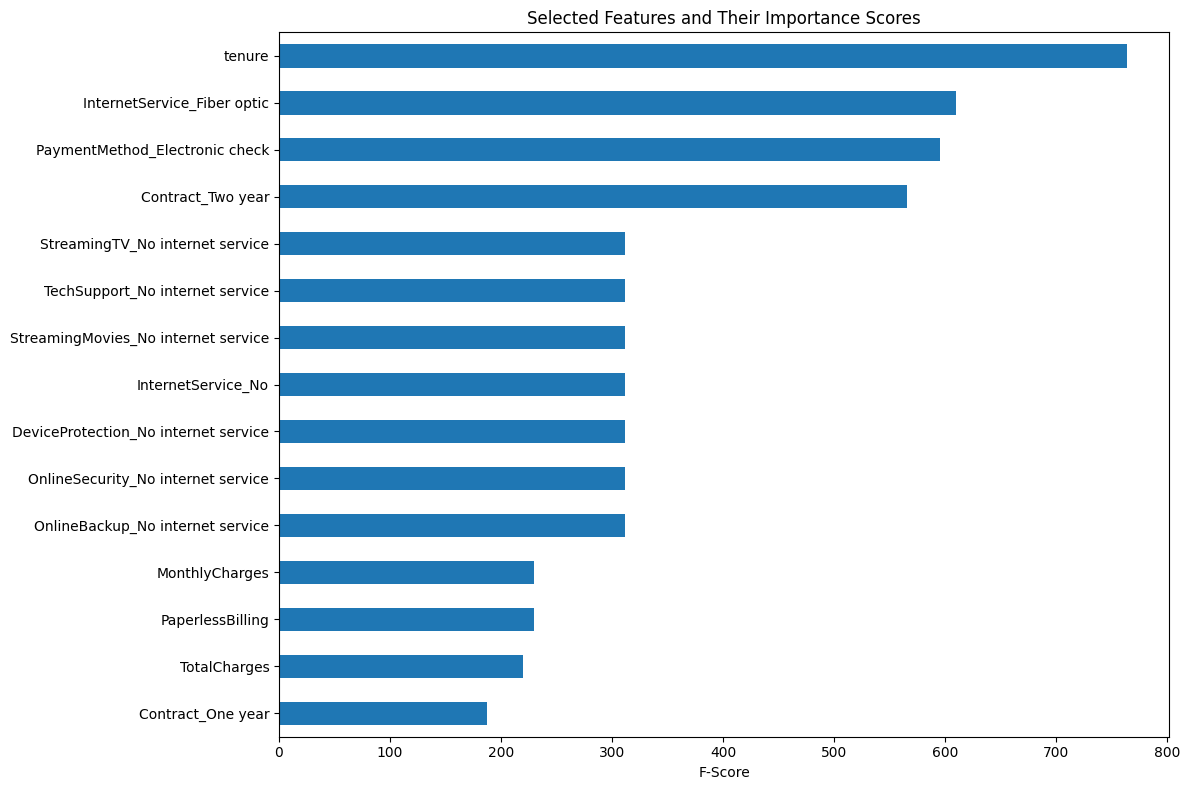


TASK 4: MODEL SELECTION
Initializing multiple binary classification models for comparison:
Selected 4 models for comparison:
1. Logistic Regression: LogisticRegression
   Parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
2. Decision Tree: DecisionTreeClassifier
   Parameters: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
3. Random Forest: RandomForestClassifier
   Parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_

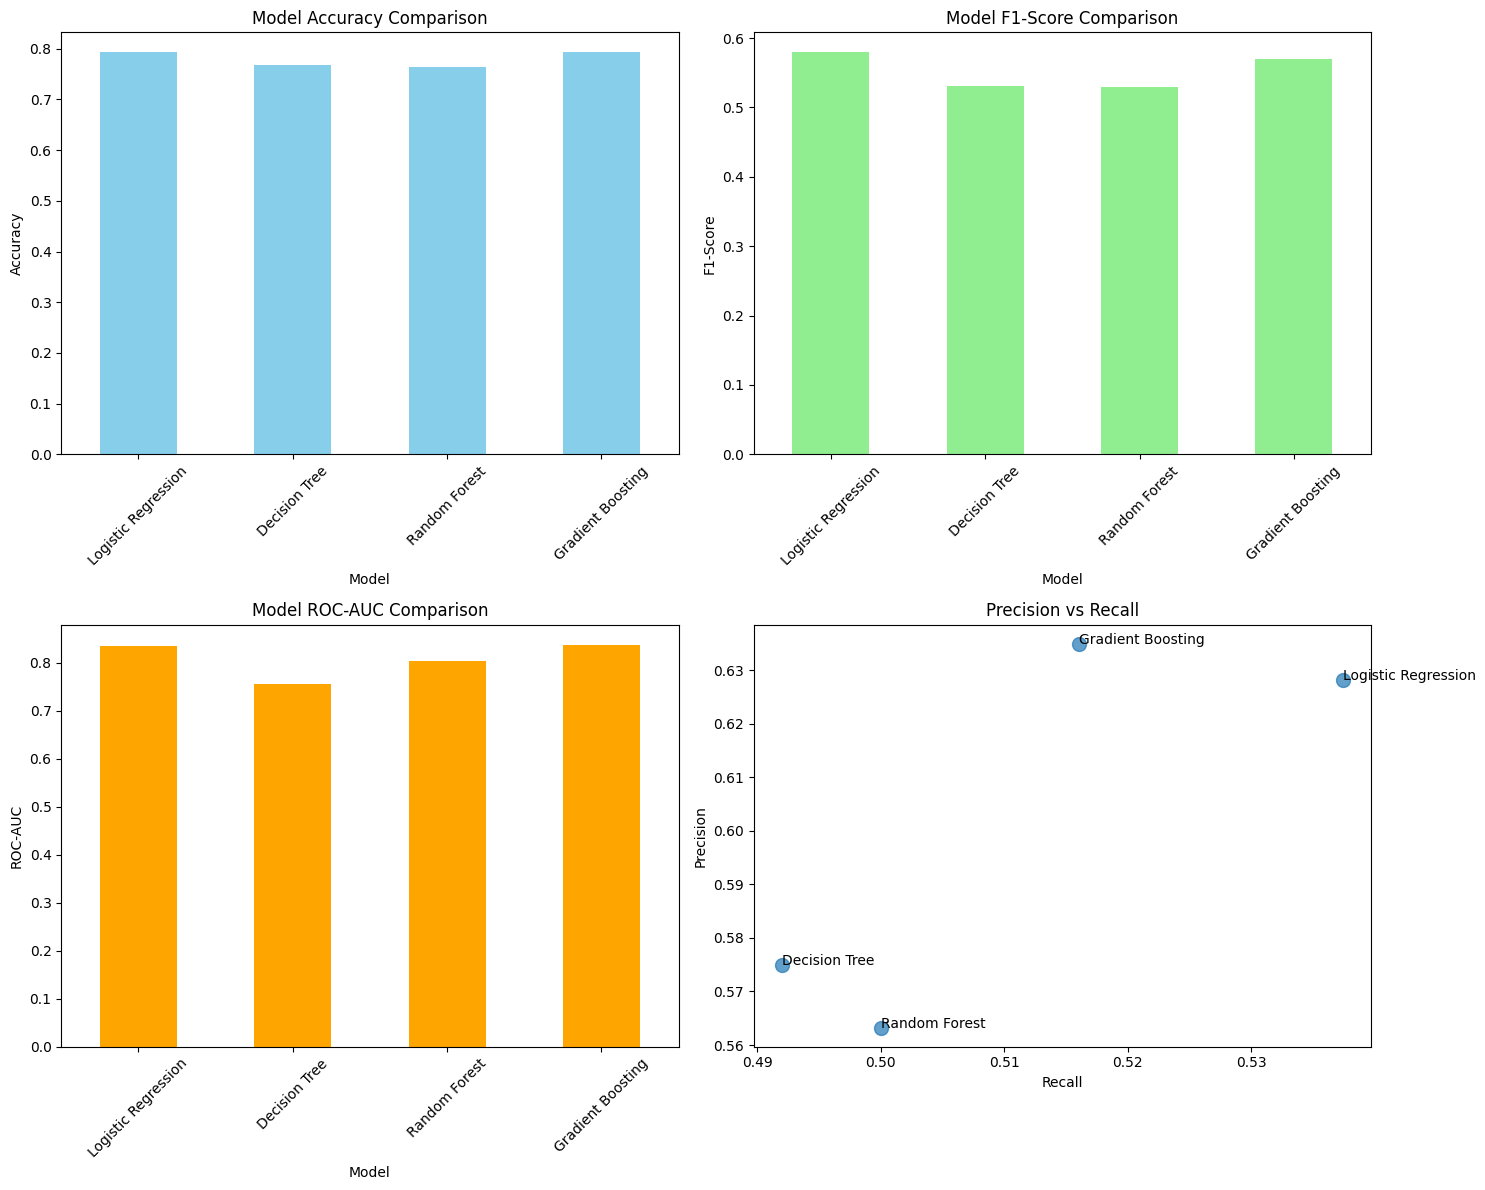

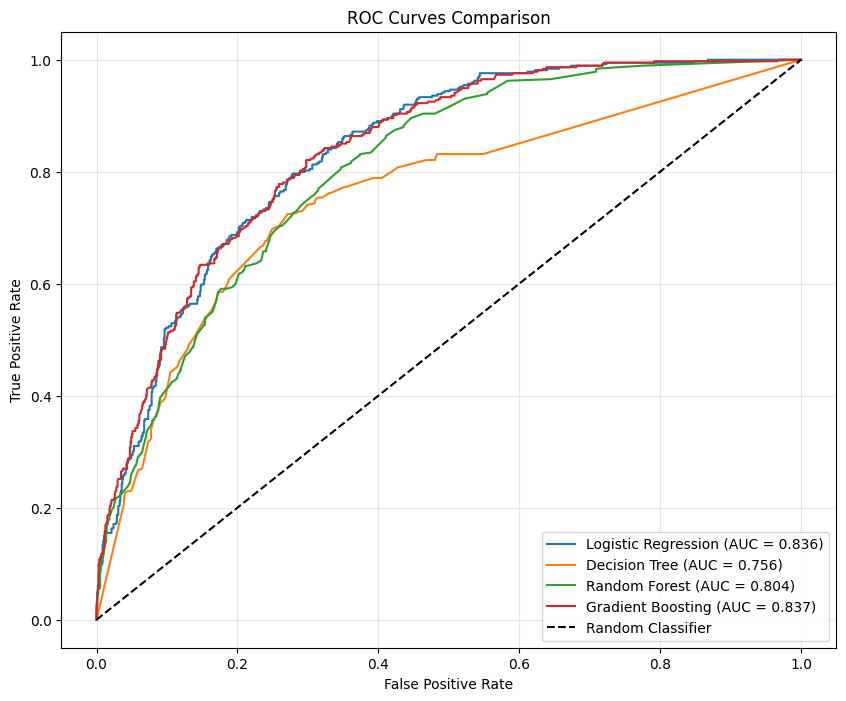


ANALYSIS COMPLETED SUCCESSFULLY!

Final Recommendations:
----------------------------------------
1. Focus on customers with high churn probability scores
2. Target retention campaigns based on selected features
3. Monitor key features that influence churn prediction
4. Regularly retrain models with new data
5. A/B test retention strategies on identified at-risk customers


In [6]:
analyzer = main()